In [1]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import plot_model

In [107]:
mobilenet = MobileNet(include_top=False, input_shape=(224, 224, 3))
pool = GlobalAveragePooling2D()(mobilenet.output)
dense = Dense(1280, activation='relu')(pool)
dropout = Dropout(0.5)(dense)
dense = Dense(1280, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)
joint_classifier = Dense(20, activation='softmax', name="Joint_Classifier")(dropout)
model = Model(inputs=mobilenet.input, outputs=joint_classifier)

17227776/17225924 [==============================] - 2s 0us/step


In [139]:
model.summary()
print(get_model_memory_usage(32, model))

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128

In [7]:
import glob
import os
from PIL import Image, ImageOps
import numpy as np

image_shape = (224, 224, 3)
data_count = 60
dataset = "Dataset"
domains = list(map(os.path.basename, glob.glob(dataset + "/*")))
classes = list(map(os.path.basename, glob.glob(dataset + "/" + domains[0] + "/*")))

img = np.zeros((len(domains) * len(classes) * data_count, *image_shape), dtype='int')
labels = np.zeros((len(domains) * len(classes) * data_count), dtype='int')

label_index = 0
label_map = {}

for j, d in enumerate(domains):
    for i, c in enumerate(classes):
        label_map[label_index] = (d, c)
        
        data = glob.glob(os.path.join(dataset, d, c, "*"))[:data_count]

        for k, im in enumerate(data):
            index = j*len(classes)*data_count + i*data_count + k
            image = ImageOps.fit(Image.open(im), image_shape[:-1], Image.ANTIALIAS)
            img[index] = image
            labels[index] = label_index
        label_index += 1

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    img, labels, test_size=0.2, stratify=labels
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="rmsprop", 
    metrics=["accuracy"]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# with tf.device('/device:GPU:0'):
#     history = model.fit(X_train,
#               y_train, 
#               epochs=100,
#               validation_split=0.2,
#               callbacks=[early_stopping_monitor]
#              )

In [40]:
print(model.evaluate(X_train, y_train))

960/960 [==============================] - 28s 29ms/sample - loss: 0.3924 - accuracy: 0.8990
[0.39244382133086525, 0.8989583]


In [6]:
from scipy.stats import entropy
from tensorflow import keras

model = keras.models.load_model('joint_classification_model')

In [38]:
y_joint = model.predict(X_train)
y_marginal = y_joint.reshape(-1,4,5)

y_domain = np.sum(y_marginal, axis=2)
y_class = np.sum(y_marginal, axis=1)

y_ind_joint = (y_domain[:,:,np.newaxis] * y_class[:,np.newaxis,:]).reshape(-1,20)

kl = sum(entropy(y_joint.T, y_ind_joint.T))
print("Total KL-divergence: ", kl)
print("Avg KL-divergence: ", kl/y_joint.shape[0])

Total KL-divergence:  29.807019806812676
Avg KL-divergence:  0.03104897896542987


In [157]:
# model.save("joint_classification_model")

INFO:tensorflow:Assets written to: joint_classification_model\assets


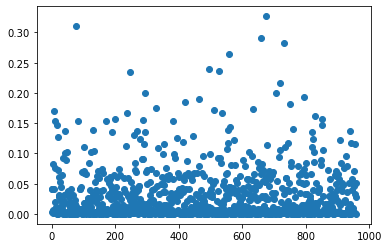

In [39]:
from matplotlib import pyplot as plt

kldiv = entropy(y_joint.T, y_ind_joint.T)

plt.scatter(range(len(kldiv)), kldiv)

In [41]:
label_map

{0: ('Art', 'Alarm_Clock'),
 1: ('Art', 'Bottle'),
 2: ('Art', 'Chair'),
 3: ('Art', 'Flowers'),
 4: ('Art', 'Helmet'),
 5: ('Clipart', 'Alarm_Clock'),
 6: ('Clipart', 'Bottle'),
 7: ('Clipart', 'Chair'),
 8: ('Clipart', 'Flowers'),
 9: ('Clipart', 'Helmet'),
 10: ('Product', 'Alarm_Clock'),
 11: ('Product', 'Bottle'),
 12: ('Product', 'Chair'),
 13: ('Product', 'Flowers'),
 14: ('Product', 'Helmet'),
 15: ('Real World', 'Alarm_Clock'),
 16: ('Real World', 'Bottle'),
 17: ('Real World', 'Chair'),
 18: ('Real World', 'Flowers'),
 19: ('Real World', 'Helmet')}

In [22]:
y_joint[52]

array([0.00231989, 0.00489728, 0.0251546 , 0.00310039, 0.00101705,
       0.00195529, 0.0039514 , 0.00341352, 0.00125199, 0.00426499,
       0.6960409 , 0.05116823, 0.00953286, 0.00227612, 0.02198557,
       0.00656799, 0.00293921, 0.15146194, 0.00237205, 0.00432867],
      dtype=float32)

In [26]:
y_ind_joint[52]

array([2.57936530e-02, 2.29722029e-03, 6.91700354e-03, 3.28423135e-04,
       1.15292380e-03, 1.04881776e-02, 9.34092386e-04, 2.81258184e-03,
       1.33542941e-04, 4.68800194e-04, 5.52079201e-01, 4.91689779e-02,
       1.48049355e-01, 7.02946493e-03, 2.46768165e-02, 1.18523166e-01,
       1.05558457e-02, 3.17839868e-02, 1.50912127e-03, 5.29774465e-03],
      dtype=float32)